# Lab work on MNIST classification using multiple machine learning algorithms 

**Objective of the work**.

The purpose of this lab work is to learn multiple machine learning algorithms for classifying handwritten digit images from a MNIST dataset.

**Work Objectives**.

* Study the MNIST dataset and its structure
* Study and implement **some** machine learning algorithms for MNIST classification
* Train models on the MNIST dataset
* Evaluate the performance of the models and compare the results
* Suggest improvements and optimizations for the models

**MNIST dataset**.

The MNIST dataset is a standard dataset for pattern recognition tasks. It consists of 70,000 handwritten digit images from 0 to 9, each image is 28x28 pixels.

## Import libraries

To work with data and models, we need the following libraries:

* numpy
* pandas
* matplotlib
* scikit-learn

In [1]:
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import torch.backends.cudnn

%matplotlib inline

torch.cuda.synchronize()
torch.cuda.empty_cache()
gc.collect()

torch.use_deterministic_algorithms(False)
torch.backends.cudnn.benchmark = True

try:
    torch.backends.cudnn.version()
except:
    pass

print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("cuDNN benchmark?", torch.backends.cudnn.benchmark)
print("is Use Deterministic Algorithms?", torch.backends.cudnn.deterministic)

cuda = torch.device('cuda')
print(torch.cuda.get_device_properties(cuda))

Is cuda available? True
Is cuDNN version: 8600
cuDNN enabled?  True
cuDNN benchmark? True
is Use Deterministic Algorithms? False
_CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Laptop GPU', major=8, minor=6, total_memory=7973MB, multi_processor_count=48)


Load dataset

In [2]:
num_workers = 0
batch_size = 1000
valid_size = 0.2

MODEL_NAME = "SimpleNet"

train_data_path = '../../input/emnist/emnist-balanced-train.csv'
test_data_path = '../../input/emnist/emnist-balanced-test.csv'

# train_data_path = '../../input/emnist/emnist-bymerge-train.csv'
# test_data_path = '../../input/emnist/emnist-bymerge-test.csv'

# The classes of this balanced dataset are as follows. Index into it based on class label
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
num_classes = len(class_mapping)

print(num_classes)
# source data: https://arxiv.org/pdf/1702.05373.pdf

47


In [3]:
mnist_train = pd.read_csv(train_data_path, header=None).to_numpy()
mnist_test = pd.read_csv(test_data_path, header=None).to_numpy()
row_num = 8

np.unique(mnist_test[:, 0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [4]:
images_train = np.float32(np.reshape(mnist_train[:, 1:], (mnist_train.shape[0], 28, 28, 1))) / 255
numbers_train = mnist_train[:, 0]
images_test = np.float32(np.reshape(mnist_test[:, 1:], (mnist_test.shape[0], 28, 28, 1))) / 255
numbers_test = mnist_test[:, 0]

images_train = np.transpose(images_train, [0, 3, 2, 1])
images_test = np.transpose(images_test, [0, 3, 2, 1])

images_train = torch.tensor(images_train, device=cuda).to(non_blocking=True)
numbers_train = torch.tensor(numbers_train, device=cuda).to(non_blocking=True)
images_test = torch.tensor(images_test, device=cuda).to(non_blocking=True)
numbers_test = torch.tensor(numbers_test, device=cuda).to(non_blocking=True)

print(images_train.shape)
print(numbers_train.shape)
print(images_test.shape)
print(numbers_test.shape)

# print("Classes: ", np.unique(numbers_train.cpu()))

from importlib import reload
import SimpleNet

reload(SimpleNet)

model = SimpleNet.SimpleNet(num_classes)
model.cuda()

torch.Size([112800, 1, 28, 28])
torch.Size([112800])
torch.Size([18800, 1, 28, 28])
torch.Size([18800])


SimpleNet(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(3, 3), padding=(4, 4))
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 128, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=47, bias=True)
)

torch.Size([1, 1, 32, 32])



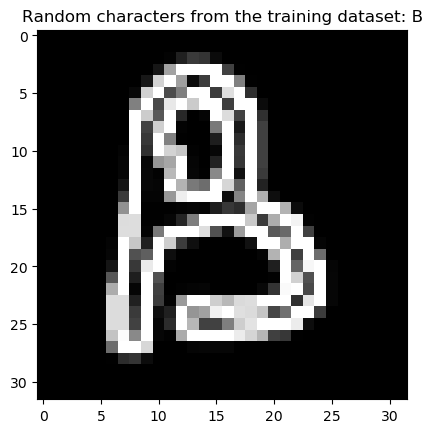

In [5]:
reload(SimpleNet)

model = SimpleNet.SimpleNet(num_classes)
model.cuda()

number_train = 133 # np.random.randint(0, images_test.shape[0])
image = images_test[number_train:number_train+1, 0:1, :, :]
image = model.prepare(image).cpu()
print(image.shape)

plt.imshow(
    image[0,0,:,:]
    , cmap=plt.cm.binary_r, vmin=0, vmax=1)
plt.title(f"Random characters from the training dataset: {class_mapping[numbers_test.cpu().numpy()[number_train]]}")
print()

Data is flipped

In [6]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader

from importlib import reload
import SimpleNet

reload(SimpleNet)

# Picking Fashion-MNIST dataset

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomInvert(p=0.5),
])
# transforms.RandomInvert(p=0.5),
normalize_transforms = transforms.Compose([
    transforms.Resize(size=SimpleNet.IMAGE_SIZE, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize((0.5,), (0.5,)),
])
# transforms.Normalize((0.5,), (0.5,)),

train_data = TensorDataset(images_train, numbers_train)
test_data = TensorDataset(images_test, numbers_test)

# Finding indices for validation set
num_train = len(train_data)
indices = list(range(num_train))
#Randomize indices
np.random.shuffle(indices)

split = int(np.floor(num_train * valid_size))
train_index, test_index = indices[split:], indices[:split]

# Making samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(test_index)

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [7]:
from importlib import reload
import torchvision.models
import SimpleNet
import torch.optim as optim

reload(SimpleNet)

model = SimpleNet.SimpleNet(num_classes)
model.cuda()
print(model)

# loss function
criterion = nn.CrossEntropyLoss()

train_losses = []
valid_losses = []

# tracks validation loss change after each epoch
minimum_validation_loss = np.inf

SimpleNet(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(3, 3), padding=(4, 4))
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 128, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=47, bias=True)
)


In [8]:
learning_rate = 0.01
learning_momentum = 0.9
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=learning_momentum)

# epochs to train for
epochs = 30

for epoch in range(1, epochs + 1):
    clear_output(wait=True)

    train_loss = 0
    valid_loss = 0

    # training steps
    model.train()

    index = 0
    for batch_index, (data, target) in enumerate(train_loader):
        index += 1
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = model(normalize_transforms(train_transforms(data)))
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # forward pass
        output = model(normalize_transforms(train_transforms(data)))
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        valid_loss += loss.item() * data.size(0)

    # average loss calculations
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Display loss statistics
    print(
        f'Текущая Эпоха: {len(train_losses)}\nTraining Loss: {round(train_loss, 6)}\nValidation Loss: {round(valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if valid_loss <= minimum_validation_loss:
        print(f'Validation loss уменьшилась с {round(minimum_validation_loss, 6)} до {round(valid_loss, 6)}')
        torch.save(model.state_dict(), f'{MODEL_NAME}.pt')
        minimum_validation_loss = valid_loss
        print('Сохранение новой модели')

    plt.plot(train_losses, 'g')
    plt.plot(valid_losses, 'r')
    plt.ylim([0, max(np.max(np.array(train_losses)), np.max(np.array(train_losses)), 0.0) * 1.1])
    plt.xlabel("Эпоха")
    plt.ylabel("Точность")
    plt.legend(["Training loss", "Validation loss"])
    plt.show()

KeyboardInterrupt: 

In [ ]:
from importlib import reload
import SimpleNet

reload(SimpleNet)

model_new = SimpleNet.SimpleNet(num_classes)
model_new.cuda()
model_new.load_state_dict(torch.load(f'{MODEL_NAME}.pt'))

output_max = None
output_min = None

In [ ]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

model_new.eval()

for batch_idx, (data, target) in enumerate(test_loader):
    # forward pass
    output = model_new(normalize_transforms(train_transforms(data)))

    local_max = np.max(output.detach().cpu().numpy(), axis=0)
    local_min = np.min(output.detach().cpu().numpy(), axis=0)
    if output_max is None:
        output_max = local_max
    else:
        output_max = np.max(np.array([local_max, output_max]), axis=0)
    if output_min is None:
        output_min = local_min
    else:
        output_min = np.min(np.array([local_min, output_min]), axis=0)

    # batch loss
    loss = criterion(output, target)
    # test loss update
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(
        correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print(f'Итоговое значение функции потерь: {round(test_loss, 6)}')

for i in range(num_classes):
    if class_total[i] > 0:
        print(f'Точность на тестовой выборке класса {class_mapping[i]}: {round(100 * class_correct[i] / class_total[i], 2)}%')
    else:
        print(f'Точность на тестовой выборке класса {class_mapping[i]}s: N/A (нет обучающих примеров)')

print(
    f'Полная точность на тестовой выборке: {round(100. * np.sum(class_correct) / np.sum(class_total), 2)}% {np.sum(class_correct)} распознано из {np.sum(class_total)}')

output_max = np.array(output_max)
output_min = np.array(output_min)
print(f"output_min = {output_min}\noutput_max = {output_max}")